# In Silico Analyses of RFdiffusion Pipeline Experiments
### Question:
Is there an optimal number of RFdiffusion structures to the number of ProteinMPNN sequences per structure that maximizes success rate while also minimizing computation time?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore') 

file = "pdl1-600x15.out.txt"

In [2]:
# calculate the estimated computation time (minutes) for each step of the pipeline
# note that this varies by run but the relative times should be similar

if file == 'tbl1-600x15.out.txt':
    def rfdiffusion_time(num_structs):
        return 2.8*num_structs  # 2.8 minutes per structure

    def proteinmpnn_time(num_structs, num_seqs):
        return num_structs*(5/60 + (1.6/60)*num_seqs)  # 1.6 seconds per sequence + 5 additional seconds per structure

    def alphafold2_time(num_structs, num_seqs):
        return (35/60)*num_structs*num_seqs + 45  # 35 seconds per design + 45 minutes to initialize af2


    # given the number of sequences and estimated total computation time, get the number of structures

    def get_num_structs(num_seqs, total_time):
        # total_time = (173*structs + 36.6*structs*seqs + 2700)/60

        return (60*total_time - 2700) / (173 + 36.6*num_seqs)

elif file == 'tblr1-600x15.out.txt':
    def rfdiffusion_time(num_structs):
        return 1.63*num_structs
    def proteinmpnn_time(num_structs, num_seqs):
        return num_structs*(5/60 + (1/60)*num_seqs)
    def alphafold2_time(num_structs, num_seqs):
        return (21/60)*num_structs*num_seqs + 45
    def get_num_structs(num_seqs, total_time):
        return (60*total_time - 2700) / (102.8 + 22*num_seqs)
    
elif file == 'pdl1-600x15.out.txt':
    def rfdiffusion_time(num_structs):
        return 0.64*num_structs
    def proteinmpnn_time(num_structs, num_seqs):
        return num_structs*(2/60 + (1.875/60)*num_seqs)
    def alphafold2_time(num_structs, num_seqs):
        return (9.5/60)*num_structs*num_seqs + 45
    def get_num_structs(num_seqs, total_time):
        return (60*total_time - 2700) / (40.4 + 11.375*num_seqs)


In [3]:
# read output scores text file
df = pd.read_csv(file, delim_whitespace=True)

# extract structure and sequence numbers
df['struct'] = df['description'].str.split('_').apply(lambda x: int(x[-4]))
df['seq'] = df['description'].str.split('_').apply(lambda x: int(x[-2]))

## Analysis 1: same # structures, increasing # sequences

In [4]:
# create dataframe: rows = structures, columns = sequences, values = successful (True/False)

df1 = df.pivot(index='struct', columns='seq', values='successful')
num_seqs = len(df1.columns)

In [5]:
# analysis 1: using all RFdiffusion structures, sample a different number of sequences (1, 2, 3, etc.)
#df1_plot = pd.DataFrame(index = range(1, num_seqs+1))

df1_plot_data = []

for iteration in range(10):
    num_passing_structs = []

    for i in range(1, num_seqs+1):
        column_name = "sample_" + str(i)
        
        # sample `i` random sequences
        df1[column_name + '_seqs'] = df1.apply(lambda row: list(np.random.choice(range(num_seqs), i, replace=False)), axis=1)
        
        # check if at least one sequence is successful
        df1[column_name + '_min_1_true'] = df1.apply(lambda row: row[row[column_name + '_seqs']].any(), axis=1)
        
        # calculate the total number of RFdiffusion structures with at least one successful sequence
        num_passing_structs.append(df1[column_name + '_min_1_true'].sum())
        
    df1_plot_data.append(num_passing_structs)
    print(iteration, end=' ')

# plot data
df1_plot = pd.DataFrame(df1_plot_data, columns=range(1, num_seqs+1))
#df1_plot.to_csv('df1_plot'+file+'.csv', index=False)

0 1 2 3 4 5 6 7 8 9 

Text(0, 0.5, '# rfdiffusion structures with >=1 passing seq')

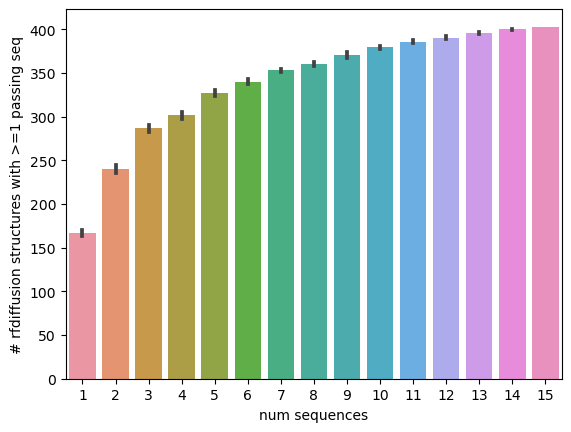

In [6]:
sns.barplot(data=df1_plot)
plt.xlabel('num sequences')
plt.ylabel('# rfdiffusion structures with >=1 passing seq')

Text(0, 0.5, 'estimated computation time (min)')

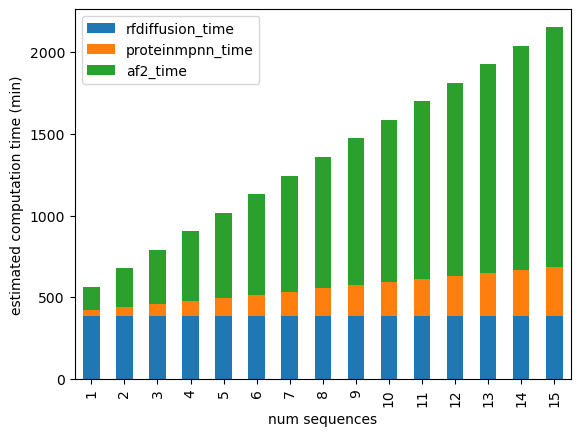

In [7]:
# calculate the computation time for constant # structures, increasing # sequences

rfd_time = []
mpnn_time = []
af2_time = []

num_structs = len(df1)
for i in range(1, num_seqs+1):
    rfd_time.append(rfdiffusion_time(num_structs))
    mpnn_time.append(proteinmpnn_time(num_structs, i))
    af2_time.append(alphafold2_time(num_structs, i))
    
df1_plot2 = pd.DataFrame(index = range(1, num_seqs+1))
df1_plot2['rfdiffusion_time'] = rfd_time
df1_plot2['proteinmpnn_time'] = mpnn_time
df1_plot2['af2_time'] = af2_time

df1_plot2.plot(kind='bar', stacked=True)
plt.xlabel('num sequences')
plt.ylabel('estimated computation time (min)')

## Analysis 2: Same total number of AF2 designs, different number of Structures and Sequences

In [8]:
# dataframe: rows = structures, columns = sequences, values = successful (true/false)

df2 = df.pivot(index='struct', columns='seq', values='successful')
total_rows = len(df2.index)
total_cols = len(df2.columns)

In [9]:
# analysis 2: for a constant number of AF2 designs (= total # rfdiffusion structures), sample a different number of structures and sequences

structs_list = []
seqs_list = []

for num_seqs in range(1, total_cols+1):
    num_structs = round(total_rows / num_seqs)  # round num structs to obtain same total number of af2 designs

    structs_list.append(num_structs)
    seqs_list.append(num_seqs)

print(structs_list)
print(seqs_list)

[600, 300, 200, 150, 120, 100, 86, 75, 67, 60, 55, 50, 46, 43, 40]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, '(600, 1)'),
  Text(1, 0, '(300, 2)'),
  Text(2, 0, '(200, 3)'),
  Text(3, 0, '(150, 4)'),
  Text(4, 0, '(120, 5)'),
  Text(5, 0, '(100, 6)'),
  Text(6, 0, '(86, 7)'),
  Text(7, 0, '(75, 8)'),
  Text(8, 0, '(67, 9)'),
  Text(9, 0, '(60, 10)'),
  Text(10, 0, '(55, 11)'),
  Text(11, 0, '(50, 12)'),
  Text(12, 0, '(46, 13)'),
  Text(13, 0, '(43, 14)'),
  Text(14, 0, '(40, 15)')])

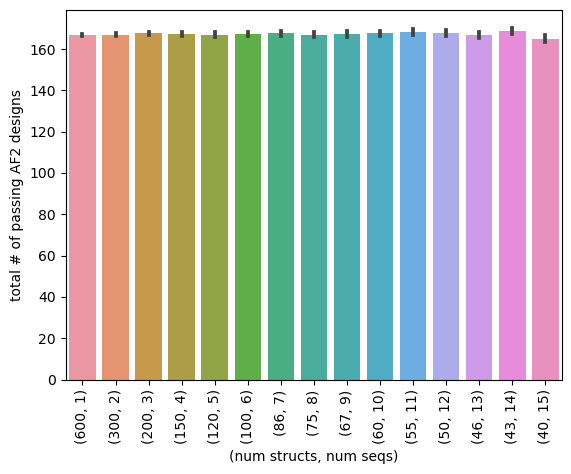

In [10]:
df2_plot_data = []

for iteration in range(1000):

    pass_list = []
    
    for i in range(len(structs_list)):
        num_structs = structs_list[i]
        num_seqs = seqs_list[i]

        df_sample = df2.sample(n=num_structs)
        df_sample = df_sample.apply(lambda row: row.sample(n=num_seqs).values, axis=1)

        df_sample = pd.DataFrame(df_sample)
        df_sample = pd.DataFrame(df_sample[0].to_list())

        num_pass = df_sample.values.sum()
        pass_list.append(num_pass)
            
    df2_plot_data.append(pass_list)
    print(iteration, end=' ')
    
df2_plot = pd.DataFrame(df2_plot_data, columns=list(zip(structs_list, seqs_list)))
df2_plot.to_csv('df2_plot'+file+'.csv', index=False)

# plot bar graph
sns.barplot(data=df2_plot)
plt.xlabel('(num structs, num seqs)')
plt.ylabel('total # of passing AF2 designs')
plt.xticks(rotation=90)

Text(0.5, 0, '# successful af2 designs')

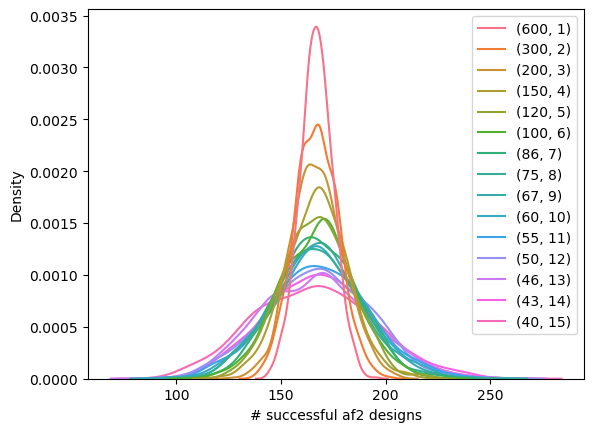

In [11]:
# plot kde

sns.kdeplot(df2_plot)
plt.xlabel('# successful af2 designs')


Text(0.5, 0, '# successful af2 designs')

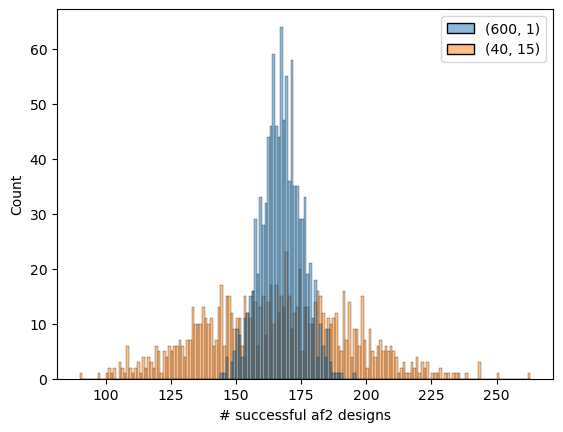

In [12]:
# plot histplot of 1 sequence vs 15 sequences

sns.histplot(df2_plot.iloc[:,[0,14]], binwidth=1)
plt.xlabel('# successful af2 designs')


Text(0, 0.5, 'estimated computation time (min)')

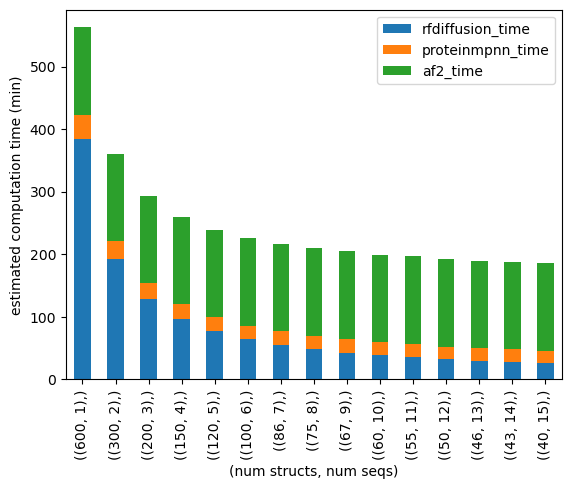

In [13]:
# estimate computation time

rfd_times = []
mpnn_times = []
af2_times = []

for i in range(total_cols):
    structs = structs_list[i]
    seqs = seqs_list[i]
    
    rfd_times.append(rfdiffusion_time(structs))
    mpnn_times.append(proteinmpnn_time(structs, seqs))
    af2_times.append(alphafold2_time(structs, seqs))

df2_plot2 = pd.DataFrame(index = [list(zip(structs_list, seqs_list))])
df2_plot2['rfdiffusion_time'] = rfd_times
df2_plot2['proteinmpnn_time'] = mpnn_times
df2_plot2['af2_time'] = af2_times
df2_plot2.plot(kind='bar', stacked=True)
plt.xlabel('(num structs, num seqs)')
plt.ylabel('estimated computation time (min)')

## Analysis #3: Constant computation time, different number of structures and sequences

Estimates for 4lg9 (350aa), binder 45-55aa, general Tesla V100 GPU, 128G RAM>

In [14]:
num_structs = len(df2.index)
num_seqs = len(df2.columns)

# for constant total time, get the number of structs/seqs that are estimated to yield that time

total_time = rfdiffusion_time(num_structs) + proteinmpnn_time(num_structs, 1) + alphafold2_time(num_structs, 1)
new_structs_list = []

for num_seqs in seqs_list:
    new_structs_list.append(round(get_num_structs(num_seqs, total_time)))
    
print(new_structs_list)
print(seqs_list)

[600, 492, 417, 362, 319, 286, 259, 236, 218, 202, 188, 176, 165, 156, 147]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


Text(0, 0.5, 'estimated computation time (min)')

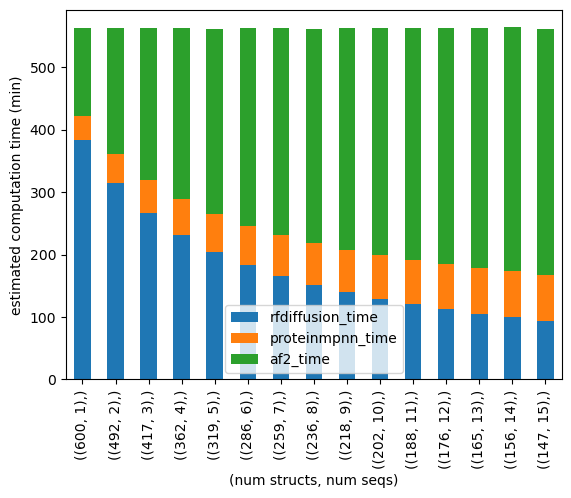

In [15]:
df2_plot3 = pd.DataFrame(index = [list(zip(new_structs_list, seqs_list))])
df2_plot3['num_structs'] = new_structs_list
df2_plot3['num_seqs'] = seqs_list
df2_plot3['total_af2_designs'] = df2_plot3['num_structs'] * df2_plot3['num_seqs']
df2_plot3['rfdiffusion_time'] = rfdiffusion_time(df2_plot3['num_structs'])
df2_plot3['proteinmpnn_time'] = proteinmpnn_time(df2_plot3['num_structs'], df2_plot3['num_seqs'])
df2_plot3['af2_time'] = alphafold2_time(df2_plot3['num_structs'], df2_plot3['num_seqs'])

# plot stacked bar chart of computation times
df2_plot3.iloc[:,3:].plot(kind='bar', stacked=True)
plt.xlabel('(num structs, num seqs)')
plt.ylabel('estimated computation time (min)')

Text(0, 0.5, 'total number of designs')

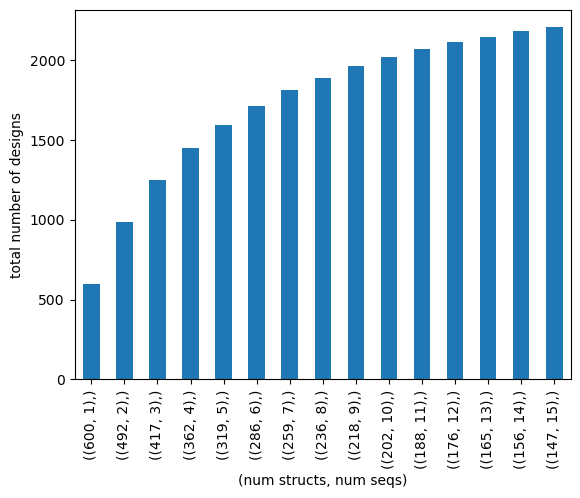

In [16]:
df2_plot3['total_af2_designs'].plot(kind='bar')
plt.xlabel('(num structs, num seqs)')
plt.ylabel('total number of designs')

In [ ]:
# sample the structs:seqs that yield the same computation time and calculate how many are successful

df2_plot4_data = []

for iteration in range(1000):

    pass_list = []
    
    for i in range(len(new_structs_list)):
        num_structs = new_structs_list[i]
        num_seqs = seqs_list[i]

        df_sample = df2.sample(n=num_structs)
        df_sample = df_sample.apply(lambda row: row.sample(n=num_seqs).values, axis=1)

        df_sample = pd.DataFrame(df_sample)
        df_sample = pd.DataFrame(df_sample[0].to_list())

        num_pass = df_sample.values.sum()
        pass_list.append(num_pass)
            
    df2_plot4_data.append(pass_list)
    print(iteration, end=' ')
    
df2_plot4 = pd.DataFrame(df2_plot4_data, columns=list(zip(new_structs_list, seqs_list)))
df2_plot4.to_csv('df2_plot4'+file+'.csv', index=True)

sns.barplot(data=df2_plot4)
plt.xlabel('(num structs, num seqs)')
plt.ylabel('# of successful AF2 designs')
plt.xticks(rotation=90)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [ ]:
sns.kdeplot(df2_plot4)
plt.xlabel('# successful AF2 designs')

In [ ]:
sns.histplot(df2_plot4.iloc[:,[0,14]], binwidth=1)
plt.xlabel('# successful af2 designs')
